In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 1
!hostname
!pwd

dv003.bridges2.psc.edu
/ocean/projects/asc170022p/mtragoza/mre-pinn/notebooks


In [3]:
import sys, os, pathlib
import numpy as np
import xarray as xr
import torch
torch.backends.cudnn.enabled = True
import matplotlib.pyplot as plt
import seaborn as sns

os.environ['DDEBACKEND'] = 'pytorch'
import deepxde

sys.path.append('..')
%aimport mre_pinn

torch.cuda.is_available()

True

In [4]:
%autoreload

cohort = mre_pinn.data.PatientCohort(patient_ids='0006', xarray_dir='../data/NAFLD_test')
#cohort = mre_pinn.data.PatientCohort.from_file('../data/NAFLD/NAFLD_2022-10-31_head10.xarrays', xarray_dir='../data/NAFLD')
#cohort.create_xarrays()
#cohort.save_xarrays()
#cohort.metadata
cohort.load_xarrays()
cohort.eval_baseline()

  0%|          | 0/1 [00:00<?, ?it/s]Loading ../data/NAFLD_test/0006/t1_pre_in.nc
Loading ../data/NAFLD_test/0006/t1_pre_water.nc
Loading ../data/NAFLD_test/0006/t1_pre_out.nc
Loading ../data/NAFLD_test/0006/t1_pre_fat.nc
Loading ../data/NAFLD_test/0006/t2.nc
Loading ../data/NAFLD_test/0006/mre_raw.nc
Loading ../data/NAFLD_test/0006/wave.nc
Loading ../data/NAFLD_test/0006/mre.nc
Loading ../data/NAFLD_test/0006/anat_mask.nc
Loading ../data/NAFLD_test/0006/mre_mask.nc
  0%|          | 0/1 [00:00<?, ?it/s]

  return key in self.data

  return key in self.data



100%|██████████| 1/1 [00:00<00:00,  4.31it/s]


In [5]:
pde = mre_pinn.pde.WaveEquation.from_name('helmholtz', detach=True)
pde

In [33]:
%autoreload

pino = mre_pinn.model.SpectralOperator(
    n_spatial_dims=3,
    n_channels_in=4,
    n_channels_out=1,
    n_spatial_freqs=128,
    n_channels_conv=32,
    n_conv_blocks=4,
    n_conv_per_block=1,
    activ_fn='g',
    omega=15/300
)
pino

SpectralOperator(
  (a_net): SpectralEncoder(
    (a_linear): Linear(in_features=4, out_features=32, bias=True)
    (conv_block1): ConvBlock(
      (conv0): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (pool): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (conv_block2): ConvBlock(
      (conv0): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (pool): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (conv_block3): ConvBlock(
      (conv0): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (pool): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (conv_block4): ConvBlock(
      (conv0): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (pool): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (x_linear): Linear(in_fe

In [34]:
%autoreload

model = mre_pinn.training.PINOModel(cohort, pino, pde, patch_size=None, batch_size=1)
model.compile(
    optimizer='adam',
    lr=1e-3,
    loss_weights=[1e0, 1e-10],
    loss=mre_pinn.training.losses.msae_loss
)   
test_eval = mre_pinn.testing.TestEvaluator(test_every=10, interact=True)

Compiling model...
'compile' took 0.000244 s



<IPython.core.display.Javascript object>


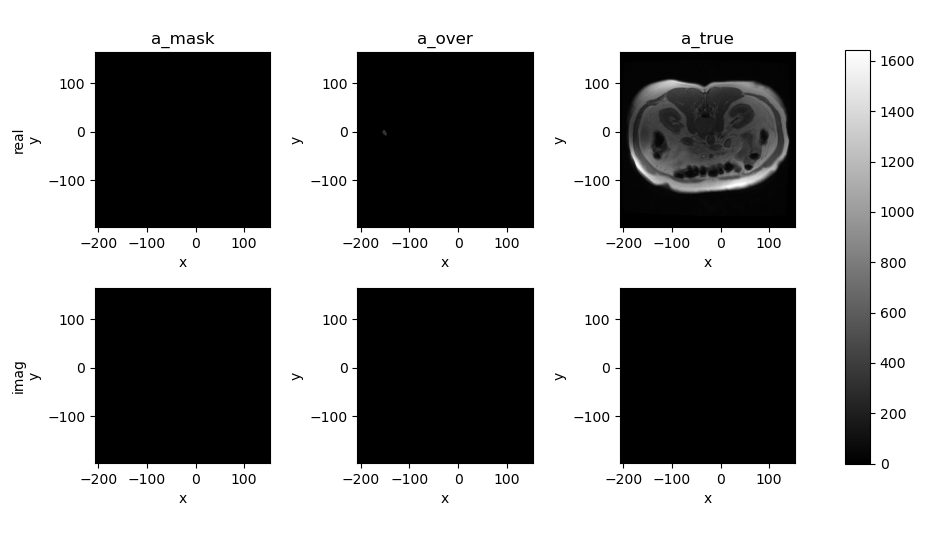

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

<IPython.core.display.Javascript object>


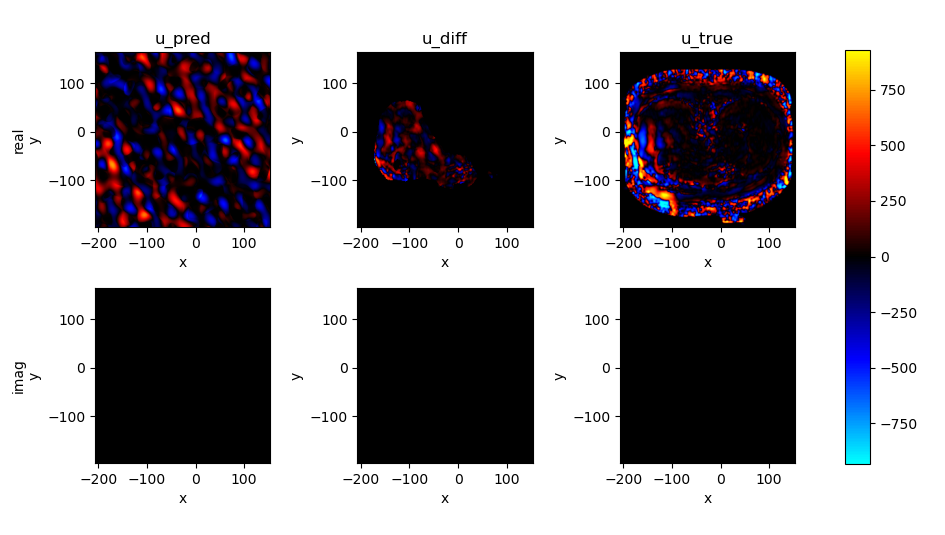

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

<IPython.core.display.Javascript object>


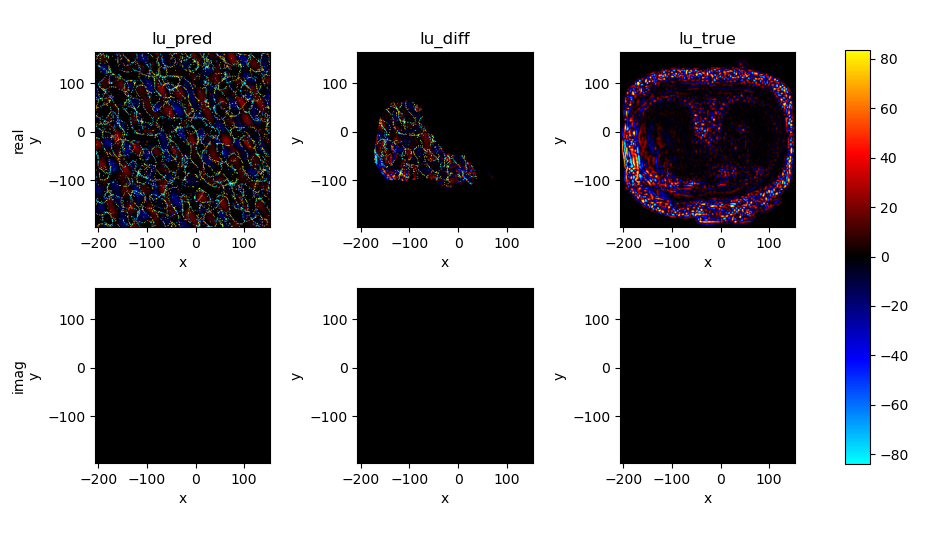

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

<IPython.core.display.Javascript object>


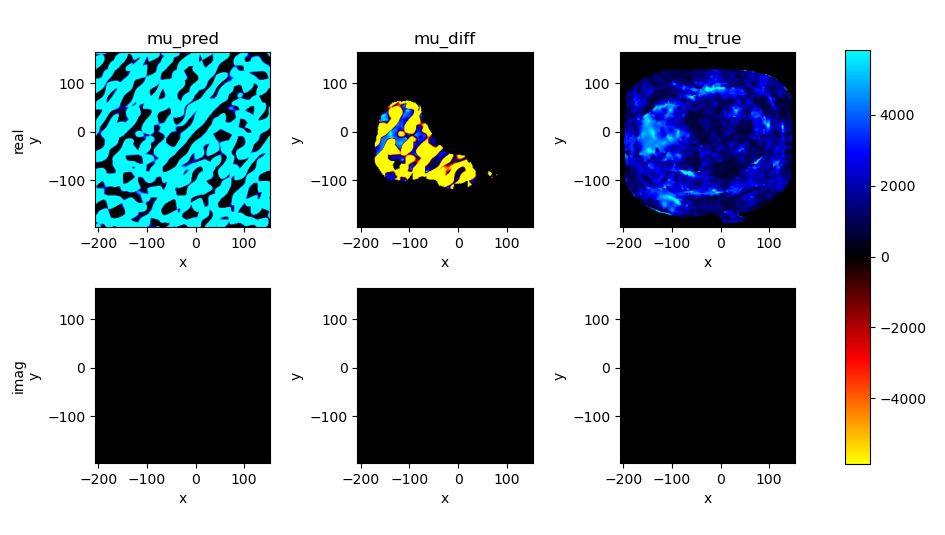

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

In [35]:
test_eval.model = model
test_eval.test()

In [ ]:
torch.backends.cudnn.enabled = False

model.train(10000, display_every=10, callbacks=[test_eval])

Training model...

0         [7.53e+03, 2.05e+02]    [7.53e+03, 2.05e+02]    []  
Time spent testing: 17.56%
10        [7.40e+03, 1.62e+09]    [7.40e+03, 1.62e+09]    []  
Time spent testing: 21.05%
20        [6.39e+03, 1.56e+11]    [6.39e+03, 1.56e+11]    []  
Time spent testing: 22.49%
30        [5.95e+03, 2.66e+11]    [5.95e+03, 2.66e+11]    []  
Time spent testing: 23.37%
40        [1.30e+04, 1.57e+12]    [1.30e+04, 1.57e+12]    []  
Time spent testing: 23.89%
50        [7.33e+03, 6.26e+11]    [7.33e+03, 6.26e+11]    []  
Time spent testing: 24.26%
60        [6.78e+03, 1.90e+11]    [6.78e+03, 1.90e+11]    []  
Time spent testing: 24.90%
70        [5.87e+03, 2.14e+11]    [5.87e+03, 2.14e+11]    []  
Time spent testing: 25.07%
80        [5.44e+03, 2.13e+11]    [5.44e+03, 2.13e+11]    []  
Time spent testing: 25.16%
90        [5.21e+03, 1.95e+11]    [5.21e+03, 1.95e+11]    []  
Time spent testing: 25.15%
100       [5.10e+03, 2.41e+11]    [5.10e+03, 2.41e+11]    []  
Time spent testing